# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 2602454 Business Intelligence System</p>

# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> Condo Price Prediction </p>

    The popularity of condominiums as a first home among Generation Y in Bangkok is increasing due to their preference for a convenient lifestyle. When making a decision to purchase, buyers consider the price of the condominium as a key factor. Therefore, the goal of this study is to create a model that can predict the selling price per square meter of a condominium in Bangkok. The purpose of this model is to assist buyers in their decision-making process by providing them with predicted prices.

<br>
<center><img src="https://cdn-images.prod.thinkofliving.com/wp-content/uploads/1/2019/08/06103238/S__152125772.jpg" width="800px"></center>

# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> This project is brought to you by </p>

* Kornkanok Klinsumalee (6341005826)
* Noppakrit Phurisuriyaroj (6341109426)
* Goman Kliaokanokphan (6341017326)
* Suramate Chokchaisuwan (6341232926)
* Dhawalrat Leelapratak (6341096926)
* Tanupat Kontha (6341072826)

# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> Outline </p>

1. Import dataset and libraries

    * 1.1 Data Cleaning
    
    * 1.2 Terminology of features and variables ที่ถูกใช้ในการทำ Model
2. EDA

    * 2.1 Data summary
    
    * 2.2 Barplot Price by District
    * 2.3 Pointplot Price Distribution for District
    * 2.4 Histogram plot
    * 2.5 Pairplot
3. Data preparation

    * 3.1 โดยกำหนด LabelEncoder ( เป็น order )
    
    * 3.2 Change categorical column to one-hot encoding
4. Models
    * 4.1 Spilt train test
    
    * 4.2 FLAML
    * 4.3 Find Best Model
    * 4.4 Feature Important
5. Prediction
6. Reference


<a id="import-libraries"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 1. Import dataset and libraries</p>

In [175]:
import re
import os
import csv
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from ipywidgets import interact
import seaborn as sns
plt.rcParams['font.family'] = 'Tahoma'

กลุ่มของนิสิตได้ทำการ Scraping ข้อมูลมาจาก Website DDProperty* ซึ่งมีการรวบรวมข้อมูลของคอนโดที่มีการประกาศขายอยู่บน Website ในหลายเขต ได้แก่
1. เขตสาทร
2. เขตปทุมวัน
3. เขตบางคอแหลม
4. เขตบางรัก
5. เขตคลองสาน
6. เขตธนบุรี
7. เขตยานนาวา

ผลลัพธ์ของการ scraping จะออกมาในรูปแบบของไฟล์ .csv (comma separated values) จึงได้มีการรวมข้อมูลให้อยู่ใน DataFrame เดียวกัน


In [176]:
def get_data(path):
    dir_path = path
    for filename in os.listdir(dir_path):
        if filename.endswith('.csv'):
            with open(os.path.join(dir_path, filename)) as csvfile:
                data = list(csv.reader(csvfile))
            yield data

def create_dataframe(data):
    for d in data:
        try:
            df = pd.DataFrame(d[1:], columns=d[0])
            yield df
        except Exception as e:
            print(f"Error creating DataFrame: {e}")

data = get_data('data/')
df_list = list(create_dataframe(data))
df = reduce(lambda df1,df2: pd.merge(df1,df2,how ='outer'), df_list)
df = df.iloc[:, 5:]

In [177]:
def clean_space(df, columns: dict):
    df_copy = df.copy()
    for column in columns:
            df_copy[column] = df_copy[column].astype(str)
            df_copy[column] = df_copy[column].str.replace('\n', '').str.strip()
            df_copy[column] = df_copy[column].apply(lambda x: re.sub(r'\s{2,}', columns[column], x))
            yield column, df_copy[column]

def replace_column_data(df, columns_data: dict):
    df_replaced = df.copy()
    for key in columns_data.keys():
        df_replaced[key] = columns_data[key]
    return df_replaced

clean_columns = dict(clean_space(df, {"facility": ',', "space": ' '}))
df = replace_column_data(df, clean_columns)

In [178]:
df.head()

,name,price,Province,area (keat),district,bedroom,bathroom,space,year,type,furniture,station,floor,facility
0,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ","17,500,000",กรุงเทพ,บางคอแหลม,บางคอแหลม,3,3,240 ตร.ม.,"December, 2006",ขายขาด,null,สถานีใกล้เคียง10 นาที (720 ม.) ถึง B11 BRT สะพ...,null,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว..."
1,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ","19,000,000",กรุงเทพ,บางคอแหลม,บางคอแหลม,3,3,230 ตร.ม.,"December, 2006",ขายขาด,null,สถานีใกล้เคียง10 นาที (720 ม.) ถึง B11 BRT สะพ...,null,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว..."
2,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,"2,500,000",กรุงเทพ,บางคอแหลม,บางโคล่,1,1,39 ตร.ม.,"December, 2004",null,null,สถานีใกล้เคียง2 นาที (150 ม.) ถึง B10 BRT เจริ...,null,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว..."
3,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,"3,100,000",กรุงเทพ,บางคอแหลม,บางโคล่,1,1,40 ตร.ม.,"December, 2004",null,null,สถานีใกล้เคียง2 นาที (150 ม.) ถึง B10 BRT เจริ...,null,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว..."
4,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,"28,500,000",กรุงเทพ,บางคอแหลม,บางโคล่,1,1,39 ตร.ม.,"December, 2004",null,null,สถานีใกล้เคียง2 นาที (150 ม.) ถึง B10 BRT เจริ...,null,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว..."


<a id="2"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 1.1 Data Cleaning</p>

เนื่องจากข้อมูลที่ได้จากการ scrape นั้น มีข้อมูลที่หลากหลาย เนื่องจากมี format ที่ไม่ตายตัวและอนุญาตให้คนขายสามารถป้อนเนื้อความได้อย่างอิสระ จึงเป็นปัญหาสำหรับการนำมาใช้ ยกตัวอย่างเช่น 
1. พื้นที่ขนาด 32 ตารางเมตร
2. พื้นที่ขนาด 32 ตร.ม.
3. พื้นที่ขนาดใหญ่ 32 ตรม.

จึงส่งผลให้ต้องมีการ clean ข้อมูลและแปลงข้อมูลให้มีความ integrity มากที่สุด เพื่อที่จะใช้ในทำ Model และลดข้อผิดพลาดที่อาจจะเกิดขึ้น ซึ่งในกรณีนี้คณะผู้จัดทำได้ใช้ Regular Expression (REGEX) และ การแปลงประเภทของข้อมูลให้อยู่ในรูปแบบที่ต้องการ (Object -> Float)

In [179]:
df = df.replace(["null", "ไม่มีข้อมูล"], np.NaN)

df["price"] = df["price"].replace(r",", '', regex = True).astype(float)

df["space"] = df["space"].str.extract(r"([\d\.]+[\d+])").astype(float)

df["year"] = df["year"].str.extract(r"(\d{4})").astype(float)

df["bedroom"] = df["bedroom"].replace("สตูดิโอ", 0).astype(float)

df["bathroom"] = df["bathroom"].astype(float)

df["floor"] = df["floor"].astype(float)

In [180]:
df.rename(columns={"area (keat)": "area", "Province": "province"}, inplace=True)

In [181]:
def station(df):
    for i in range(len(df)):
        if isinstance(df['station'][i], float) and np.isnan(df['station'][i]):
            yield np.NaN, np.NaN, np.NaN
        else:
            match = re.search(r'สถานีใกล้เคียง\d+ นาที \((\d+) ม.\) ถึง (\w+)\s(\w+)\s[ก-๙]+', str(df['station'][i]))
            yield match.groups() if match else np.nan

test_df = pd.DataFrame(station(df))
test_df.columns = ['distance','station_id','station_type']
test_df["distance"] = test_df["distance"].astype(float)
df = pd.merge(df, test_df, left_index=True, right_index=True, how="left")
df = df.drop(columns="station")

In [182]:
df.head()

,name,price,province,area,district,bedroom,bathroom,space,year,type,furniture,floor,facility,distance,station_id,station_type
0,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",17500000.0,กรุงเทพ,บางคอแหลม,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,NaN,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว...",720.0,B11,BRT
1,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",19000000.0,กรุงเทพ,บางคอแหลม,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,NaN,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว...",720.0,B11,BRT
2,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,2500000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว...",150.0,B10,BRT
3,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,3100000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,40.0,2004.0,NaN,NaN,NaN,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว...",150.0,B10,BRT
4,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,28500000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,"สิ่งอำนวยความสะดวก & สถานที่ใกล้เคียง,สิ่งอำนว...",150.0,B10,BRT


ในส่วนของ Facilities นั้นก็จะมีความแตกต่างกันค่อนข้างมาก จึงได้มีการพิจารณาทำเป็นหมวดหมู่ จากประเด็นในเรื่องของความอิสระในการป้อนข้อมูลเข้ามาในระบบของผู้ใช้ ทำให้พบว่าสิ่งเดียวกัน มีการเขียนออกไปในหลากหลายรูปแบบ <br>

จึงได้มีการทำ Groupping เพื่อที่จะนำไปใช้ในการคำนวณราคาคอนโด ว่าปัจจัยใดที่สำคัญที่มีผลต่อการทำนายราคา

In [183]:
def separate_facilities(df, **kwargs):
    for col_name, keywords in kwargs.items():
        df[col_name] = df["facility"].apply(lambda x: True if isinstance(x, str) and any(keyword in x for keyword in keywords) else False)
    return df

df = separate_facilities(df, 
                            is_Security = ['รักษาความปลอดภัย 24 ชม.','ระบบรักษาความาปลอดภัยการเข้า-ออกอาคาร'],
                            is_Laundry =['ซัก อบ รีด', 'เครื่องซักผ้า'],
                            is_Parking_Lot= ['ที่จอดรถ','ลานจอดรถ','ลานจอดรถใต้ดิน','โรงรถ'],
                            is_Bus_Stop= ['ป้ายรถเมล์'],
                            is_Cleaning=['พนักงานทำความสะอาด'],
                            is_Fitness =['ฟิตเนส','ลู่วิ่ง',],
                            is_Convenient_Store = ['มินิมาร์ท',],
                            is_Balcony=['ระเบียง',],
                            is_View = ['วิวทะเล','วิวสระว่ายน้ำ','วิวเมือง','สวน/วิวสวนธรรมชาติ'],
                            is_Sport_Facility = ['สนามบาส','สนามสควอช','สนามหัดเล่นกอล์ฟ','สนามเด็กเล่น','สนามเทนนิส','สนามแบดมินตัน','ห้องบิลเลียด','ห้องยิมนาสติก'],
                            is_Pool =['สปา สระว่ายน้ำ','สระว่ายน้ำ','สระว่ายน้ำส่วนตัว','สระว่ายน้ำเพื่อความสนุก','สระเด็ก',],
                            is_Park= ['สวนสาธารณะ',],
                            is_Garden = ['สวนส่วนตัว',],
                            is_corner_room = ['ห้องมุม',])

df = df.drop(columns="facility")

In [184]:
df.head()

,name,price,province,area,district,bedroom,bathroom,space,year,type,furniture,floor,distance,station_id,station_type,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room
0,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",17500000.0,กรุงเทพ,บางคอแหลม,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False
1,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",19000000.0,กรุงเทพ,บางคอแหลม,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False
2,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,2500000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,150.0,B10,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False
3,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,3100000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,40.0,2004.0,NaN,NaN,NaN,150.0,B10,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False
4,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,28500000.0,กรุงเทพ,บางคอแหลม,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,150.0,B10,BRT,True,False,True,False,False,False,False,False,False,True,True,False,False,False


<a id="3"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 1.2 Terminology of features and variables ที่ถูกใช้ในการทำ Model</p>

<center>

| Column Name   | Explanation                                     |
| ------------- | -------------------------------------------------|
| name          | Name of the property or listing                 |
| price         | Price of the property or listing                |
| province      | Province where the property is located          |
| area  | Area of the property in "เขต" units            |
| district      | District where the property is located          |
| bedroom       | Number of bedrooms in the property             |
| bathroom      | Number of bathrooms in the property            |
| space         | Space or size of the property                  |
| year          | Year of construction or listing                |
| type          | Type of property selling (Long-term Lease, Outright) |
| furniture     | Furniture type (Fully-furnished, Fully-fitted, non-furnished)|
| floor         | Floor number or level of the property          |
| distance (m.) | Distance to a certain point (e.g., a station) in meters|
| station_id | ID of each station|
| station_type  | Type of nearby station (e.g., MRT, BTS, etc.)    |

</center>

In [185]:
df = df.drop(['province', 'station_type', 'area'], axis = 1)

In [186]:
df.head(3)

,name,price,district,bedroom,bathroom,space,year,type,furniture,floor,distance,station_id,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room
0,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",17500000.0,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False
1,"Supalai Casa Riva : ศุภาลัย คาซา ริวา, กรุงเทพ",19000000.0,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False
2,Lumpini Place Rama 3 - Riverview : ลุมพินี เพล...,2500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False


In [187]:
df["name"] = df["name"].str.extract(r"(?P<name>.+)[,]")
df["name"] = df["name"].str.extract(r"(?P<name>.+?[:]|.+)")
df["name"] = df["name"].str.replace(":", "").str.strip()

# Clean district column



เนื่องจากพบปัญหาว่า Users บางคนมีการกรอกข้อมูลที่ไม่ถูกต้องเข้ามา ซึ่งจะเห็นได้ว่าบางคนกรอกชื่อ Condo ลงมาในช่องทาง District (เขต) ทำให้เกิดปัญหาในการทำ Model จึงทำการ Pre-processing Data ก่อนที่จะนำเข้าไปสู่การทำ EDA และประมวลผลต่อไป

In [188]:
district_name = {'The Met Sathorn' : 'ทุ่งมหาเมฆ',
                'ASHTON Silom : แอชตัน สีลม' : 'สุริยวงศ์',
                'Nara 9 สาทร-นราธิวาส': 'ทุ่งมหาเมฆ',
                'StarView Rama 3' : 'บางโคล่',
                'Villa Sathorn':'คลองต้นไทร',
                'The Park Chidlom' : 'ลุมพินี',
                r'M สีลม \(เอ็ม สีลม\)' : 'สุริยวงศ์',
                'Supalai Premier Ratchada-Narathiwas-Sathorn : ศุภาลัย พรีเมียร์ รัชดาฯ-นราธิวาส-สาทร' : 'ช่องนนทรี',
                r'Baan Nonsi \(บ้านนนทรี\)' : 'ช่องนนทรี',
                r'CU Terrace \(ระเบียงจามจุรี\)' : 'วังใหม่',
                'ปทุมวัน โอเอซิส คอนโดมิเนียม' : 'วังใหม่',
                'สุพรีม คลาสิค คอนโดมิเนียม' : 'ทุ่งมหาเมฆ'
                }
for key in district_name:
    df.loc[df['district'].str.contains(key), 'district'] = district_name[key]

df['district'].value_counts()

ลุมพินี            1584
ทุ่งมหาเมฆ          788
คลองต้นไทร          744
สีลม                708
ช่องนนทรี           584
บางโพงพาง           391
ยานนาวา             309
ดาวคะนอง            275
บางลำภูล่าง         256
ทุ่งวัดดอน          249
สี่พระยา            248
มหาพฤฒาราม          207
บุคคโล              185
บางโคล่             182
วัดพระยาไกร         155
ตลาดพลู             143
สุริยวงศ์           115
วังใหม่              94
บางคอแหลม            78
คลองสาน              62
สำเหร่               49
รองเมือง             38
สมเด็จเจ้าพระยา      10
ปทุมวัน               9
บางยี่เรือ            7
หิรัญรูจี             6
บางรัก                1
Name: district, dtype: int64

<a id="2"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 2. EDA </p>
EDA หรือ Exploratory Data Analysis เป็นกระบวนการวิเคราะห์ข้อมูลเพื่อค้นหาความสัมพันธ์และแนวโน้มของข้อมูลในขั้นตอนต้นของการวิเคราะห์ข้อมูล โดยเป้าหมายของ EDA คือการสำรวจและสรุปผลข้อมูลเพื่อให้เกิดความเข้าใจกับข้อมูลที่มีอยู่และเตรียมข้อมูลเพื่อนำไปใช้ในการวิเคราะห์ต่อไป

<a id="2.1"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 2.1 Data summary</p>

In [189]:
# df.head(3)

<a id="2.2"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 2.2 Barplot Price by District</p>

การสร้างกราฟแท่ง (barplot) เพื่อแสดงราคาเฉลี่ยของที่อยู่อาศัยในแต่ละเขตของเมือง มีจุดประสงค์เพื่อช่วยให้ผู้วิเคราะห์สามารถจัดการข้อมูลได้อย่างมีประสิทธิภาพและเข้าใจง่ายขึ้น โดยจะแสดงราคาเฉลี่ยของแต่ละเขตและเรียงลำดับเขตตามราคาเฉลี่ย และถ้าราคาเฉลี่ยของเขตนั้นๆ อยู่ในกลุ่มราคาสูงจะใช้สีม่วงแตกต่างจากเขตที่อยู่ในกลุ่มราคาต่ำ


In [190]:
# avg_price_by_district = df.groupby('district')['price'].mean().sort_values(ascending=False)

# # create barplot with sorted order
# plt.figure(figsize=(15,6))
# color = ['tab:purple' if i < 5 else 'tab:grey' for i in range(len(df))]
# sns.barplot(x=df['district'], y=df['price']/1e6, order=avg_price_by_district.index, errorbar=None, palette = color)
# plt.title('Price by District (sorted by average price)')
# plt.xticks(rotation=45)
# plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
# plt.ylabel("Price (Million)")
# plt.show()

<div style="border-radius:10px; border:#800080 solid; padding: 10px; background-color: #c8a2c8; font-size:100%; font-family:Times_New_Roman; text-align:left">

<h3 align="left"><font color='black'>Insights</font></h3>

<font color='black'>

จากกราฟที่ได้สร้างขึ้นจะสามารถดูได้ว่า กราฟที่เป็นสีม่วงแสดงถึงเขตที่มีราคาเฉลี่ยสูงที่สุดในเมือง โดยมีเขตที่สูงสุดอยู่ที่บางโพงพาง ตามลำดับด้วยเขตคลองต้นไทร ลุมพินี สีลม และยานนาวาตามลำดับ ซึ่งอาจแสดงถึงความเป็นพื้นที่ที่เป็นที่นิยมอยู่ในกลุ่มผู้ที่มีรายได้สูงและความชื้นชอบที่จะอาศัยในพื้นที่เมืองที่เป็นศูนย์กลางของธุรกิจและกิจกรรมสังคม โดยผู้ที่ต้องการอาศัยในเขตเหล่านี้จะต้องมีความพร้อมทางการเงินที่สูงมากกว่าเขตอื่นๆ เนื่องจากราคาที่จะต้องจ่ายในการซื้อหรือเช่าที่อยู่อาศัยในพื้นที่นี้จะสูงกว่า

</font>

<a id="2.3"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 2.3 Pointplot Price distribution for district</p>

การสร้างกราฟจุด (Pointplot) แสดงการกระจายตัวของราคาในแต่ละปีของเขตที่เลือก จากนั้นจึงนำผลลัพธ์ที่ได้จากกราฟมาวิเคราะห์และใช้เป็นข้อมูลในการตัดสินใจเลือกเขตที่เหมาะสมต่อการอาศัย โดยจะเลือกดูข้อมูลราคาในแต่ละปี เพื่อดูแนวโน้มของราคาในเขตนั้นๆ และหากมีการเปลี่ยนแปลงราคาในปีหนึ่งๆ จะได้ทราบเหตุผลว่าเกิดจากสาเหตุอะไร ซึ่งข้อมูลดังกล่าวจะช่วยให้ผู้วิเคราะห์เข้าใจราคาในแต่ละเขตและปีได้มากขึ้น และสามารถตัดสินใจเลือกเขตที่เหมาะสมกับความต้องการของตนเองได้ง่ายขึ้นด้วย

In [191]:
district_names = df["district"].unique()
# district_names 

In [192]:
# @interact(District=district_names)
# def price_year(District='ลุมพินี'):
#     plt.figure(figsize=(10,5))
#     graph = df[df['district'].isin([District])]

#     year_data = graph[["year", "price"]].dropna() # drop NaN values and assign the returned DataFrame to year_data

#     year_data['year'] = year_data['year'].apply(lambda x: '{:.0f}'.format(x))

#     sns.pointplot(x=year_data["year"].astype(int), y=year_data['price'], color='indigo', errorbar=None)
#     plt.title(f'Price distribution for {District}')
#     plt.xticks(rotation=45)

#     ax = plt.gca()

#     def y_axis_numformat(y, pos):
#         return "{:,.0f}".format(y)
#     plt.ylim(0, None)

#     # Apply the formatter to the y-axis
#     ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_axis_numformat))
#     plt.show();

<div style="border-radius:10px; border:#800080 solid; padding: 10px; background-color: #c8a2c8; font-size:100%; font-family:Times_New_Roman; text-align:left">

<h3 align="left"><font color='black'>Insights</font></h3>

<font color='black'>

* การเปลี่ยนแปลงของราคาคอนโด อาจเกิดจากปัจจัยหลายประการ เช่น การเปลี่ยนแปลงของเศรษฐกิจ การเปลี่ยนแปลงในการพัฒนาที่ดินในพื้นที่ การเปลี่ยนแปลงในแนวโน้มการซื้อขาย การตัดสินใจของนักลงทุน การเปลี่ยนแปลงในนโยบายของรัฐ ทำให้ราคาคอนโดเพิ่มขึ้นหรือลดลงได้ในแต่ละปี

* แนวโน้มเพิ่มขึ้นตั้งแต่ปี 2017 ของลุมพินี อาจจะมีสาเหตุมาจาก สภาพเศรษฐกิจของพื้นที่ในช่วงเวลานั้น ความต้องการของตลาดเพิ่มมากขึ้น การพัฒนาโครงสร้างพื้นฐานและการปรับปรุงสิ่งอำนวยความสะดวกที่ดีขึ้น

</font>

<a id="2.4"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid "> 2.4 Histogram plot </p>

เราสามารถพิจารณาข้อมูลแต่ละตัวแปรว่ามีการกระจายตัวแบบไหน โดยจะสังเกตได้จากการพล็อตข้อมูลเป็นช่วงค่า และความถี่ของค่าในแต่ละช่วง ซึ่งสามารถสรุปข้อมูลพื้นฐานของแต่ละตัวแปรได้อย่างง่ายดาย และเป็นการตรวจสอบความสมดุลของข้อมูลว่ามีค่าที่ผิดปกติหรือไม่ ช่วยให้เราตัดสินใจเลือกใช้โมเดลในการทำนายและวิเคราะห์ต่อไปได้อย่างถูกต้อง

In [193]:
# plot_column = df[['price','bedroom','bathroom', 'space', 'year', 'floor', 'distance']]
# plot_column

In [194]:
# for plots in plot_column.columns:
#     sns.histplot(df[plots])
#     plt.show()

<div style="border-radius:10px; border:#800080 solid; padding: 10px; background-color: #c8a2c8; font-size:100%; font-family:Times_New_Roman; text-align:left">

<h3 align="left"><font color='black'>Insights</font></h3>

<font color='black'>

- Column ที่เรานำมาวิเคราะห์ข้อมูลมีดังนี้ 'price','bedroom','bathroom', 'space', 'year', 'floor', 'distance' จะเป็นแกน X ที่แสดงข้อมูลของ feature นั้นๆ แกน Y จะแสดงจำนวนครั้งที่ข้อมูลในแต่ละช่วง (bin) โดยจำนวนครั้งจะแสดงด้วยการนับจำนวน instances ของข้อมูลในแต่ละ bin ซึ่งสามารถเป็นไปได้ว่าจะเป็นจำนวนของ record หรือ instances ของข้อมูลที่แตกต่างกันในชุดข้อมูลนั้นๆ
- มีแค่ column year เท่านั้นที่หลังจากทำการ histrogram plot ได้มีข้อมูลเป็นเบ้ซ้าย อาจจะเพราะด้วยธุรกิจประเภทคอนโดเป็นที่นิยมมากขึ้นในแต่ละปี และมีแนวโน้มจะเพิ่มมากขึ้นอีกในปีต่อ ๆ ไป


</font>

<a id="2.5"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 2.5 Pairplot </p>

Pair Plot ของข้อมูลที่สนใจ ซึ่งจะแสดงความสัมพันธ์ระหว่าง features ต่าง ๆ ในรูปแบบของ scatter plot โดยจะแสดงผลของแต่ละ feature ที่เลือกในแนวตั้งและแนวนอน และจะแสดงความสัมพันธ์ระหว่าง features ที่สนใจ หากความสัมพันธ์เป็นเชิงเส้นกันแน่ จะมีแนวโน้มที่จะมีจุดกระจายแบบเป็นเส้นตรง แต่หากเป็นเชิงโค้ง จะมีการกระจายที่แตกต่างกันและอาจแสดงความสัมพันธ์ที่ซับซ้อนขึ้น

In [195]:
# sns.pairplot(plot_column, vars=['price','bedroom','bathroom', 'space', 'year', 'floor', 'distance'], 
#              plot_kws={'alpha': .4})
# plt.show()
# plt.clf()

In [196]:
rows = [312, 313, 1022, 1374, 2461, 3462, 3463, 3465, 3466, 3797, 6529, 6447, 925, 1931, 2461, 2744, 2745, 3210, 3221, 3331, 4557, 5428, 2822, 2897, 4092, 4269, 4354, 4413, 4591, 5175, 5191, 5527, 5594, 5628, 4564, 2662, 7076]
df = df.drop(index=rows)

<div style="border-radius:10px; border:#800080 solid; padding: 10px; background-color: #c8a2c8; font-size:100%; font-family:Times_New_Roman; text-align:left">

<h3 align="left"><font color='black'>Insights</font></h3>

<font color='black'>

- หลังจาก pairplot เสร็จแล้ว อาจจะมีการตรวจสอบข้อมูลและพบว่ามี outliers หรือข้อมูลที่ผิดปกติที่อาจจะมีผลกระทบต่อการวิเคราะห์และสรุปข้อมูล ดังนั้นเพื่อให้ผลการวิเคราะห์และสรุปข้อมูลมีความถูกต้องและน่าเชื่อถือมากขึ้น
- Chatrium Residence Riverside (data = 73 floors, research = 36 floors)
- Ivy Sathorn 10 (data = 77 floors, research = 29 floors)
- The Infinity (data = 77 floors, research = 40 floors)
- The Station Sathon Bangrak (data = 73 floors, research = 17 floors)
- Four Seasons Private Residences (data = 73 floors, research = 73 floors) -> Conflict in terms of rooms in one floor

</font>

<a id="3"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 3. Data preparation</p>

ในขั้นตอน Data Preparation นั้น เราจะทำการเตรียมข้อมูลให้พร้อมสำหรับการนำไปใช้ในการวิเคราะห์ โดยเราจะทำการตรวจสอบและแก้ไขข้อมูลที่ไม่ถูกต้องหรือขาดหายไป เช่น การลบข้อมูลที่ซ้ำกัน การแก้ไขข้อมูลที่หายไป การแปลงข้อมูลให้อยู่ในรูปแบบที่เหมาะสมกับการวิเคราะห์ เช่น การเปลี่ยนข้อมูลจากข้อความเป็นตัวเลข การกำหนดชื่อและตัวแปรให้เหมาะสม ซึ่งการทำ Data Preparation เป็นขั้นตอนสำคัญที่ช่วยให้ผลการวิเคราะห์มีความน่าเชื่อถือและแม่นยำมากยิ่งขึ้น


<a id="3.1"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 3.1 โดยกำหนด LabelEncoder ( เป็น order )</p>

`ตกแต่งครบ =  2`

`มีบางส่วน  =   1`

`ไม่มี        = 0`

In [197]:
df['furniture'].unique()

array([nan, 'ตกแต่งครบ', 'มีบางส่วน', 'ไม่มี'], dtype=object)

In [198]:
furniture = {'ตกแต่งครบ' : 2, 'มีบางส่วน' : 1, 'ไม่มี' : 0}

df['furniture_encoded'] = df['furniture'].map(furniture)
df = df.drop('furniture', axis =1 )
df.head(5)


,name,price,district,bedroom,bathroom,space,year,type,floor,distance,station_id,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room,furniture_encoded
0,Supalai Casa Riva,17500000.0,บางคอแหลม,3.0,3.0,240.0,2006.0,ขายขาด,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
1,Supalai Casa Riva,19000000.0,บางคอแหลม,3.0,3.0,230.0,2006.0,ขายขาด,NaN,720.0,B11,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
2,Lumpini Place Rama 3 - Riverview,2500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
3,Lumpini Place Rama 3 - Riverview,3100000.0,บางโคล่,1.0,1.0,40.0,2004.0,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN
4,Lumpini Place Rama 3 - Riverview,28500000.0,บางโคล่,1.0,1.0,39.0,2004.0,NaN,NaN,150.0,B10,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN


<a id="3.2"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 3.2 Change categorical column to one-hot encoding </p>

การทำ One-hot encoding เป็นเทคนิดที่ใช้ในการจัดการข้อมูลก่อนนำไปสร้าง Model ซึ่งโดยปกติแล้วโมเดล machine learning ไม่สามารถประมวลผลข้อมูลที่เป็น categorical ได้โดยตรง เนื่องจากโมเดลนั้นทำงานโดยการคำนวณค่าตัวเลข ดังนั้นจึงต้องแปลงข้อมูลที่เป็น categorical เป็นรูปแบบของตัวเลขก่อนจึงนำไปสร้างโมเดล machine learning

One-hot encoding มีหลักการคือ การนำข้อมูลที่เป็น Categorical มาสร้างเป็นคอลัมน์ใหม่สำหรับแต่ละค่าในตัวแปร categorical แล้วกำหนดให้มีค่าเป็น 1 หรือ 0 ตามลำดับ โดยที่ 1 จะอยู่ที่ตำแหน่งของค่านั้น และ 0 จะเป็นค่าอื่น ๆ ทั้งหมด

ในที่นี่ Feature ที่เราแบ่งมาทำเป็น One-hot encoding คือ District, Type และ Station_id  

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7441 entries, 0 to 7476
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 7432 non-null   object 
 1   price                7433 non-null   float64
 2   district             7441 non-null   object 
 3   bedroom              7388 non-null   float64
 4   bathroom             7366 non-null   float64
 5   space                7438 non-null   float64
 6   year                 6638 non-null   float64
 7   type                 6639 non-null   object 
 8   floor                4192 non-null   float64
 9   distance             6580 non-null   float64
 10  station_id           6580 non-null   object 
 11  is_Security          7441 non-null   bool   
 12  is_Laundry           7441 non-null   bool   
 13  is_Parking_Lot       7441 non-null   bool   
 14  is_Bus_Stop          7441 non-null   bool   
 15  is_Cleaning          7441 non-null   b

In [200]:
category_column = ['type','station_id']

In [201]:
df_dummy = pd.get_dummies(df['district'], prefix='แขวง',prefix_sep='' ,drop_first=True)
df = pd.merge(df, df_dummy, left_index=True, right_index=True , how = "inner")
df = df.drop('district', axis = 1)

In [202]:
for col in category_column:
    df_dummy = pd.get_dummies(df[col], drop_first=True)
    df = pd.merge(df, df_dummy, left_index=True, right_index=True , how = "inner")
    df = df.drop(col, axis = 1)

In [203]:
df.head()

,name,price,bedroom,bathroom,space,year,floor,distance,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room,furniture_encoded,แขวงคลองสาน,แขวงช่องนนทรี,แขวงดาวคะนอง,แขวงตลาดพลู,แขวงทุ่งมหาเมฆ,แขวงทุ่งวัดดอน,แขวงบางคอแหลม,แขวงบางยี่เรือ,แขวงบางรัก,แขวงบางลำภูล่าง,แขวงบางโคล่,แขวงบางโพงพาง,แขวงบุคคโล,แขวงปทุมวัน,แขวงมหาพฤฒาราม,แขวงยานนาวา,แขวงรองเมือง,แขวงลุมพินี,แขวงวังใหม่,แขวงวัดพระยาไกร,แขวงสมเด็จเจ้าพระยา,แขวงสำเหร่,แขวงสีลม,แขวงสี่พระยา,แขวงสุริยวงศ์,แขวงหิรัญรูจี,เช่าซื้อระยะยาว 30 ปี,เช่าระยะยาว,B10,B11,B12,B2,B3,B4,B5,B6,B7,B8,B9,BL24,BL25,BL26,BL27,BL28,BL30,E1,E14,E2,E3,G2,G3,RN07,S1,S10,S11,S2,S3,S4,S5,S6,S7,S8,S9,W1
0,Supalai Casa Riva,17500000.0,3.0,3.0,240.0,2006.0,NaN,720.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Supalai Casa Riva,19000000.0,3.0,3.0,230.0,2006.0,NaN,720.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Lumpini Place Rama 3 - Riverview,2500000.0,1.0,1.0,39.0,2004.0,NaN,150.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Lumpini Place Rama 3 - Riverview,3100000.0,1.0,1.0,40.0,2004.0,NaN,150.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Lumpini Place Rama 3 - Riverview,28500000.0,1.0,1.0,39.0,2004.0,NaN,150.0,True,False,True,False,False,False,False,False,False,True,True,False,False,False,NaN,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [204]:
df.columns

Index(['name', 'price', 'bedroom', 'bathroom', 'space', 'year', 'floor',
       'distance', 'is_Security', 'is_Laundry', 'is_Parking_Lot',
       'is_Bus_Stop', 'is_Cleaning', 'is_Fitness', 'is_Convenient_Store',
       'is_Balcony', 'is_View', 'is_Sport_Facility', 'is_Pool', 'is_Park',
       'is_Garden', 'is_corner_room', 'furniture_encoded', 'แขวงคลองสาน',
       'แขวงช่องนนทรี', 'แขวงดาวคะนอง', 'แขวงตลาดพลู', 'แขวงทุ่งมหาเมฆ',
       'แขวงทุ่งวัดดอน', 'แขวงบางคอแหลม', 'แขวงบางยี่เรือ', 'แขวงบางรัก',
       'แขวงบางลำภูล่าง', 'แขวงบางโคล่', 'แขวงบางโพงพาง', 'แขวงบุคคโล',
       'แขวงปทุมวัน', 'แขวงมหาพฤฒาราม', 'แขวงยานนาวา', 'แขวงรองเมือง',
       'แขวงลุมพินี', 'แขวงวังใหม่', 'แขวงวัดพระยาไกร', 'แขวงสมเด็จเจ้าพระยา',
       'แขวงสำเหร่', 'แขวงสีลม', 'แขวงสี่พระยา', 'แขวงสุริยวงศ์',
       'แขวงหิรัญรูจี', 'เช่าซื้อระยะยาว 30 ปี', 'เช่าระยะยาว', 'B10', 'B11',
       'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'BL24', 'BL25',
       'BL26', 'BL27', 'BL28', 'BL30', 'E1', 'E

<a id="4"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 4. Models </p>

**Model** คือ สิ่งที่ใช้สร้างความสัมพันธ์ระหว่างข้อมูลเข้า (Input data) และผลลัพธ์ที่ต้องการ (Output)  โดยใช้อัลกอริทึมเพื่อเรียนรู้และนำไปใช้ประโยชน์ต่อในอนาคต ซึ่งการสร้าง Model ใน Machine Learning จะเริ่มต้นด้วยการคัดเลือก Algorithm ที่สำคัญและเหมาะสมกับปัญหาที่ต้องการแก้ไข หลังจากนั้นจะนำข้อมูลมาแบ่งเป็น 2 ส่วนคือ  Training set และ Test set 

    - Training set : การนำข้อมูลจริงที่มีอยู่แล้วมาใส่เป็นตัวอย่างเพื่อให้เครื่องเรียนรู้ ซึ่งในการ train อาจะมีการปรับเปลี่ยน parameter ของ Algorithm เพื่อให้ model ที่ได้มีประสิทธิภาพและความแม่นยำสูงสุด โดยใช้วิธีการประมาณค่าความคลาดเคลื่อนระหว่างค่าที่คำนวณได้จาก Model กับค่าจริง (Error) และนำไปปรับปรุง Model ให้มีค่า Error น้อยลง
    - Test set : เมื่อ Model ได้รับการ Train เสร็จแล้ว จึงจะนำ Model มาทดสอบด้วยข้อมูลที่ไม่เคยเห็นมาก่อน (Test Data / Unseen Data) เพื่อวัดความแม่นยำของ Model ว่าสามารถทำนายผลลัพธ์ได้ถูกต้องเท่าใด

หลังจากได้ Model ที่มีประสิทธิภาพและมีความแม่นยำสูงสุดแล้ว จะนำข้อมูลที่ได้จากการทำ Model ไปใช้ในการทำนาย (Prediction) ของข้อมูลใหม่ที่มาถึง 



In [205]:
df['price'].dropna(inplace=True)

In [206]:
df.dropna(subset=['price'], inplace=True)

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7433 entries, 0 to 7476
Data columns (total 87 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   7424 non-null   object 
 1   price                  7433 non-null   float64
 2   bedroom                7383 non-null   float64
 3   bathroom               7361 non-null   float64
 4   space                  7432 non-null   float64
 5   year                   6631 non-null   float64
 6   floor                  4187 non-null   float64
 7   distance               6573 non-null   float64
 8   is_Security            7433 non-null   bool   
 9   is_Laundry             7433 non-null   bool   
 10  is_Parking_Lot         7433 non-null   bool   
 11  is_Bus_Stop            7433 non-null   bool   
 12  is_Cleaning            7433 non-null   bool   
 13  is_Fitness             7433 non-null   bool   
 14  is_Convenient_Store    7433 non-null   bool   
 15  is_B

<a id="4.1"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 4.1 Spilt train test </p>

In [208]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['price', 'name'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [209]:
from sklearn.metrics import mean_squared_error
from flaml import AutoML
from math import sqrt

<a id="4.2"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 4.2 FLAML </p>

**FLAML**  เป็นชื่อของ Software Open Source สำหรับการทำ Model Machine Learning และเป็นเครื่องมือที่ช่วยให้นักพัฒนาสามารถปรับแต่ง Parameter ต่างๆ ของโมเดลได้อย่าง *รวดเร็ว* และ *มีประสิทธิภาพสูง* โดยไม่ต้องใช้ทรัพยากรมาก ผู้ใช้สามารถเลือก Model Selection , Hyperparameter ที่ต้องการ มาใช้เปรียบเทียบกันได้อย่างอิสระ 

FLAML มีความน่าสนใจเป็นอย่างมาก เนื่องจากตัวหลักการของ FLAML คือการใช้โปรแกรมประมวลผลแบบโดยสาร (Meta-Learning) เพื่อเรียนรู้และเลือกใช้เทคนิคการเรียนรู้ที่เหมาะสมสำหรับข้อมูลที่กำลังจะนำมาสร้างโมเดล โดย FLAML จะปรับแต่งพารามิเตอร์ของโมเดลอัตโนมัติด้วยการใช้การค้นหาแบบกระจาย (Distributed Search) ซึ่งจะช่วยลดเวลาในการค้นหาพารามิเตอร์ที่เหมาะสมและเพิ่มประสิทธิภาพในการเทรนโมเดลได้มากทีเดียว

นอกจากนี้ FLAML ยังมีฟีเจอร์สำหรับการสร้างอัลกอริทึมเพื่อเลือกคุณลักษณะ (Feature Selection) และการจัดการข้อมูลที่ไม่สมดุล (Imbalanced Data) ได้อีกด้วย จึงเป็น Library ที่เหมาะสมที่เราจะนำมาปรับใช้กับ Dataset นี้ 



สำหรับ Dataset นี้ เราได้เลือก Model ที่นำมาเปรียบเทียบทั้งหมด 4 Model ได้แก่ 

1. Light GBM (Light Gradient Boosting)

    * ข้อดี 
        1. มีความรวดเร็วในการ train model เนื่องจากเป็นการใช้ parallel computing
           
        2. มีประสิทธิภาพการทำนายได้มากกว่า Model อื่นเมื่อต้องเจอกับข้อมูลที่มีขนาดใหญ่ และจำนวนมาก

        3. ไม่ต้องทำ Feature Scaling ก่อนเพราะสามารถรองรับ Imbalanced data ได้
        
    * ข้อเสีย
        1. ไม่เหมาะสมกับการจัดการข้อมูลที่มีขนาดเล็ก เนื่องจากอาจทำให้เกิดปัญหา overfitting ได้


2. XGBoost (Extreme Gradient Boosting)

    * ข้อดี 
        1. มีความรวดเร็วในการ train model เนื่องจากเป็นการใช้ parallel computing
        
        2. สามารถ Train Model ได้กับข้อมูลที่มีจำนวน Feature มาก และ Sample น้อย โดยไม่เกิด overfitting 

        3. สามารถจัดการกับ Missing Values ได้ดี
    * ข้อเสีย
    
        1. ต้องกำหนดจำนวน Hyperparameters มาก และถ้ากำหนดไม่เหมาะสม อาจทำให้โมเดลไม่มีประสิทธิภาพได้
        
        2. อาจใช้เวลานานในการ Train Model ในข้อมูลที่มีจำนวน Feature มาก และมีขนาดใหญ่

3. Catboost (Gradient Boosting with Categorical feature support)

    * ข้อดี 
        1. มีความรวดเร็วในการ train model เนื่องจาก เป็นการใช้ parallel computing
        
        2. สามารถ Train Model ได้กับข้อมูลที่มีจำนวน Sample น้อย
        3. สามารถจัดการกับข้อมูลที่มีความซับซ้อนสูง และมีจำนวน Feature มากได้ดี
    * ข้อเสีย

        1. อาจใช้เวลา Train Model นานกว่า Algorithm อื่น ๆ เช่น XGBoost หรือ LightGBM
        
        2. ไม่สามารถรองรับ Imbalanced Data ได้จึงจำเป็นต้องทำ Feature Selection ก่อนที่จะ Train Model
        3. ต้องกำหนดจำนวน Hyperparameters มาก และถ้ากำหนดไม่เหมาะสม อาจทำให้โมเดลไม่มีประสิทธิภาพได้
        
4. XGB limitdepth (XGBoost ที่มีการกำหนดความลึกของต้นไม้)


In [210]:
# Instantiate AutoML object
automl = AutoML()

# Define the search space for hyperparameters for regression
automl_settings = {
    "time_budget": 150,  # maximum time in seconds for training
    "metric": 'r2',
    "task": "regression",  # specify the task type as regression
    "log_file_name": "automl.log",  # log file to record the training progress
    "n_splits": 5,  # number of cross-validation folds
    "eval_method": "auto",  # specify evaluation metric as auto for regression
    "split_type": "uniform",  # type of train-test split for cross-validation
    "model_history": True,  # record model training history
    "n_jobs": 2,  # number of parallel jobs to run during training
    "estimator_list": ['lgbm', 'xgboost', 'catboost', 'xgb_limitdepth']
    # "estimator_list": ['catboost']
}

# Search for the best model and hyperparameters for regression
automl.fit(
    X_train=X_train,
    y_train=y_train,
    **automl_settings
)

#Predict
print(automl.predict(X_train))

# Access the best model and hyperparameters
best_model = automl.model.estimator
# best_log = automl.best_log


# Check if best_model is not None before accessing the best hyperparameters
if best_model is not None:
    # Print the best model and hyperparameters
    print(f"Best model: {best_model}")
    # print(f"Best hyperparameters: {best_log}")
else:
    print("No best model found.")


[flaml.automl.logger: 04-27 16:46:54] {1768} INFO - task = regression
[flaml.automl.logger: 04-27 16:46:54] {1775} INFO - Data split method: uniform
[flaml.automl.logger: 04-27 16:46:54] {1778} INFO - Evaluation method: holdout
[flaml.automl.logger: 04-27 16:46:54] {1891} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 04-27 16:46:54] {2011} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'catboost', 'xgb_limitdepth']
[flaml.automl.logger: 04-27 16:46:54] {2341} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-27 16:46:54] {2479} INFO - Estimated sufficient time budget=259s. Estimated necessary time budget=2s.
[flaml.automl.logger: 04-27 16:46:54] {2526} INFO -  at 0.2s,	estimator lgbm's best error=0.7040,	best estimator lgbm's best error=0.7040
[flaml.automl.logger: 04-27 16:46:54] {2341} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-27 16:46:54] {2526} INFO -  at 0.2s,	estimator lgbm's best error=0.7040,	best estimator lgb

<a id="4.3"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000;text-align:left; padding:10px; border-bottom: 3px solid "> 4.3 Find Best Model </p>

หลังจากใช้ FLAML ในการประมวลผลเพื่อให้ได้ model ที่ดีที่สุดแล้ว เราสามารถสร้างฟังก์ชั่นสำหรับการแสดงผลว่า เมื่อนำโมเดลไปใช้กับข้อมูลนั้น มีความแม่นยำ (score) เท่าไหร่การทำนายข้อมูล รวมทั้งแสดง ค่าคลาดเคลื่อน (error) ของการทำนาย ซึ่งในที่นี้เราจะใช้ Mean squared error และ root mean squared error เป็นตัววัด 

การหา Error ใน Machine Learning Model จะช่วยให้ผู้ใช้งานสามารถปรับปรุงโมเดลได้อย่างเหมาะสม เช่น การปรับแต่ง Hyperparameters หรือเลือกโมเดลที่เหมาะสมกับปัญหา โดยการลด Error จะหมายถึงการปรับโมเดลให้มีความแม่นยำมากขึ้นและเข้าใกล้ค่าผลลัพธ์จริงมากขึ้น

In [211]:
def display_model_score(model):

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print("-"*50)
    print(model.__class__.__name__)
    print("-"*50)
    print(f"Coefficient of Determination")
    print(f"train score : {model.score(X_train, y_train)}")
    print(f"test  score : {model.score(X_test, y_test)}")
    print("-"*50)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", sqrt(mse))
    print("-"*50)

## LGBM

In [212]:
def display_important_feature(models):
    importances = models.feature_importances_
    indices = np.argsort(importances)
    features = X.columns
    plt.figure(figsize=(15, 15))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='r', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

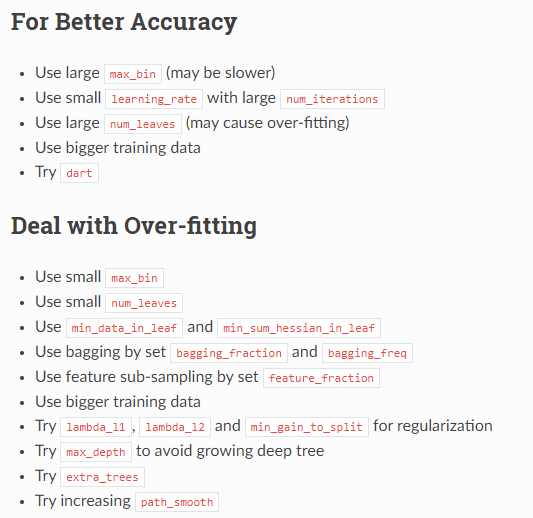

n_estimator = n_iteration


c:\Users\Acer\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE on the test set: 10600045.012129808
{'max_bin': 400, 'num_leaves': 75, 'learning_rate': 0.05, 'metric': {'l1', 'l2'}, 'verbose': -1, 'num_iterations': 300, 'early_stopping_round': None}


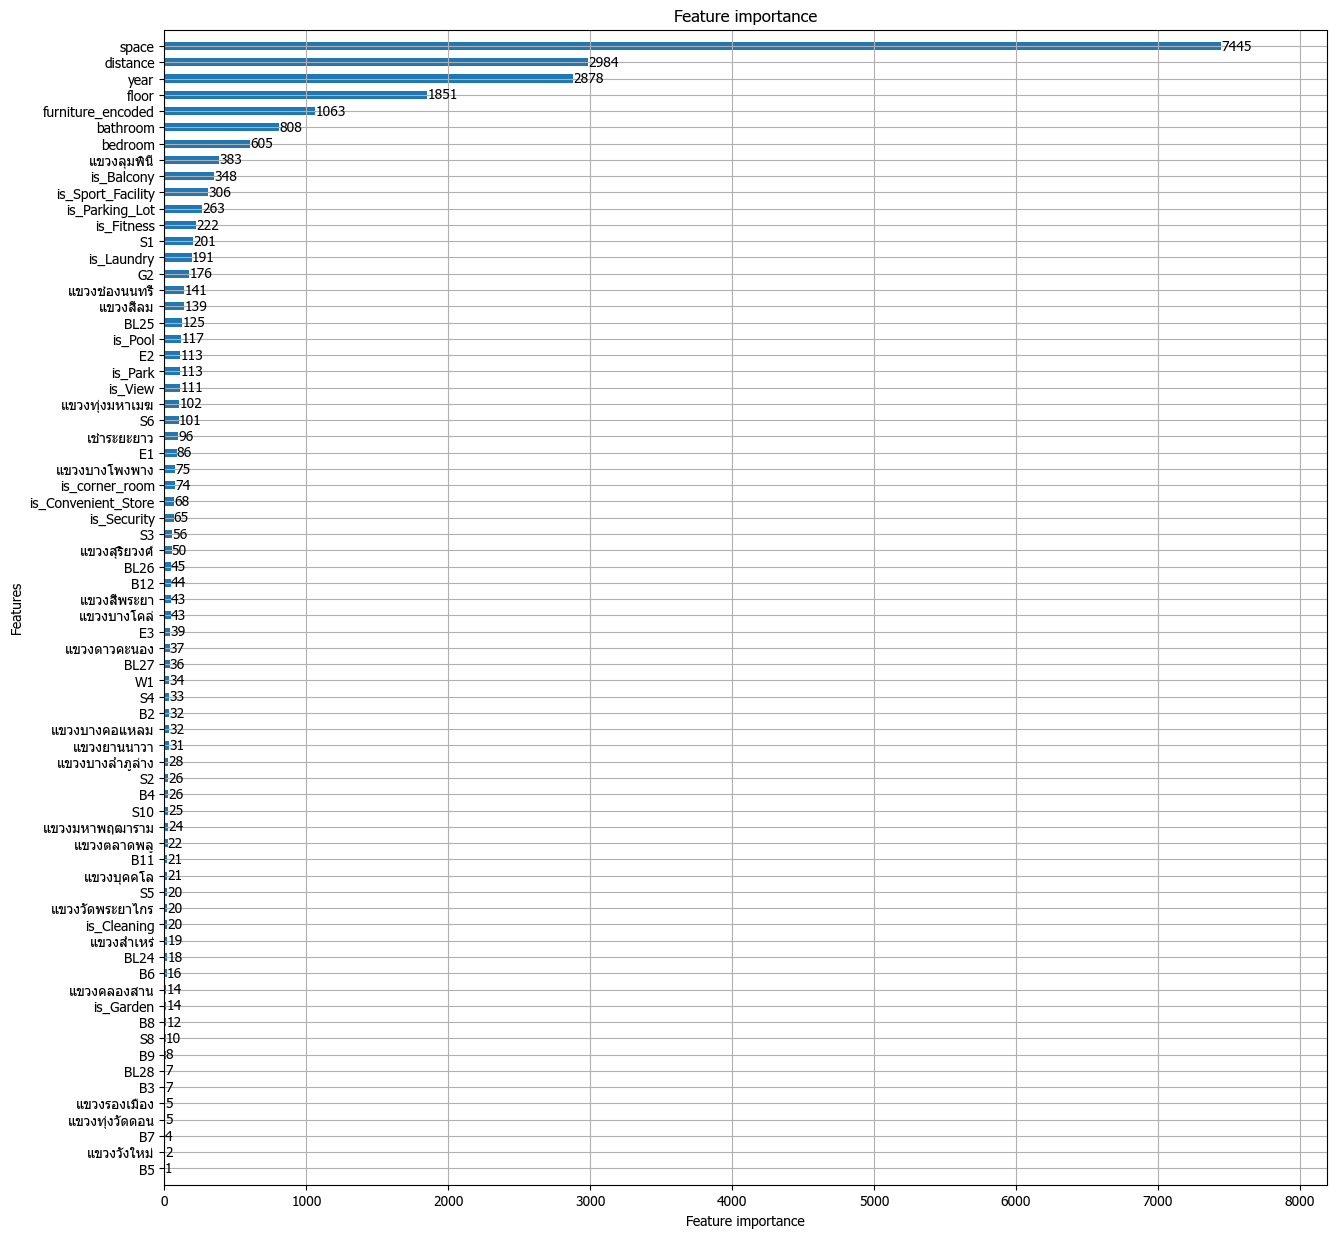

In [236]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
params = {
    # 'task': 'train', 
    # 'objective': 'regression',
    'max_bin': 400,
    'num_leaves': 75,
    'learning_rate': 0.05,
    'n_estimators':300,
    'metric': {'l2','l1'},
    'verbose': -1
}
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
# lgbm = lgb.train(params,
#                 train_set=lgb_train,
#                 valid_sets=lgb_eval,
#                 early_stopping_rounds=30
#                 )
lgbm = lgb.train(params,
                train_set=lgb_train,
                )
# lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE on the test set:', rmse)
print(lgbm.params)

# display_model_score(lgbm)
fig, ax = plt.subplots(figsize=(15, 15))
lgb.plot_importance(lgbm, height=0.5, ax=ax)
plt.show()
# display_important_feature(lgbm)

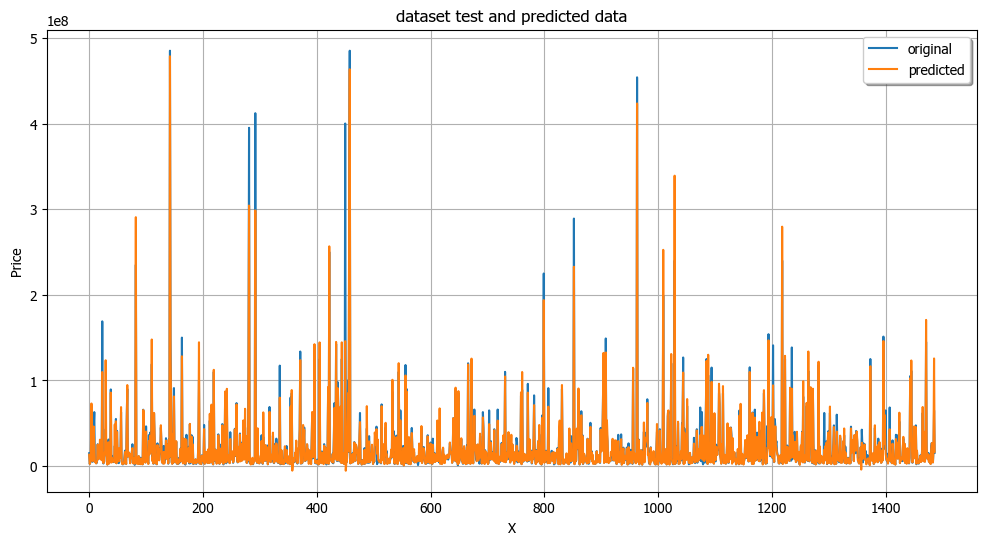

In [214]:
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

<a id="4.4"></a>
## <p style="font-family:'Times_New_Roman'; text-align:left; font-size:20px; font-weight:1000; text-align:left; padding:10px; border-bottom: 3px solid"> 4.4 Feature Important </p>

การหา Feature Importance เป็นการวิเคราะห์ว่าแต่ละ Feature ในข้อมูลมีผลกระทบต่อผลลัพธ์ของโมเดล Machine Learning อย่างไร ซึ่งจะช่วยให้ผู้ใช้งานสามารถเข้าใจได้ว่า Feature ใดบ้างที่สำคัญและมีผลต่อผลลัพธ์ของโมเดลมากที่สุด ผู้ใช้งานสามารถนำ Feature นั้นมาใช้ในการ Train Model อย่างเฉพาะเจาะจง หรือลบ Feature ที่ไม่สำคัญออกจากข้อมูลได้ ซึ่งจะช่วยให้ผู้ใช้งานสามารถดำเนินการปรับปรุงและพัฒนาโมเดลได้อย่างมีประสิทธิภาพมากขึ้น


In [215]:
def display_important_feature(models):
    importances = models.feature_importances_
    indices = np.argsort(importances)
    features = X.columns
    plt.figure(figsize=(15, 15))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='r', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [216]:
print(best_model.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': [], 'colsample_bylevel': 1.0, 'colsample_bynode': None, 'colsample_bytree': 0.5205884501511658, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': 'lossguide', 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2081754789854463, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 0, 'max_leaves': 57, 'min_child_weight': 0.14351112488946924, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 155, 'n_jobs': 2, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': 0.001284075275758194, 'reg_lambda': 6.061915809501551, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 1.0, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': 0, 'use_label_encoder': False}


In [217]:
# best_model.fit(X_train, y_train)
# display_model_score(best_model)
# display_important_feature(best_model)

## XGBoost

In [218]:
# max_delta_step=None, max_depth=0, max_leaves=32,
#             min_child_weight=1.6472242103693322, missing=nan,
#             monotone_constraints=None, n_estimators=2239, n_jobs=2,
#             num_parallel_tree=None, predictor=None, random_state=None,

RMSE on the test set: 11989532.053900477
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


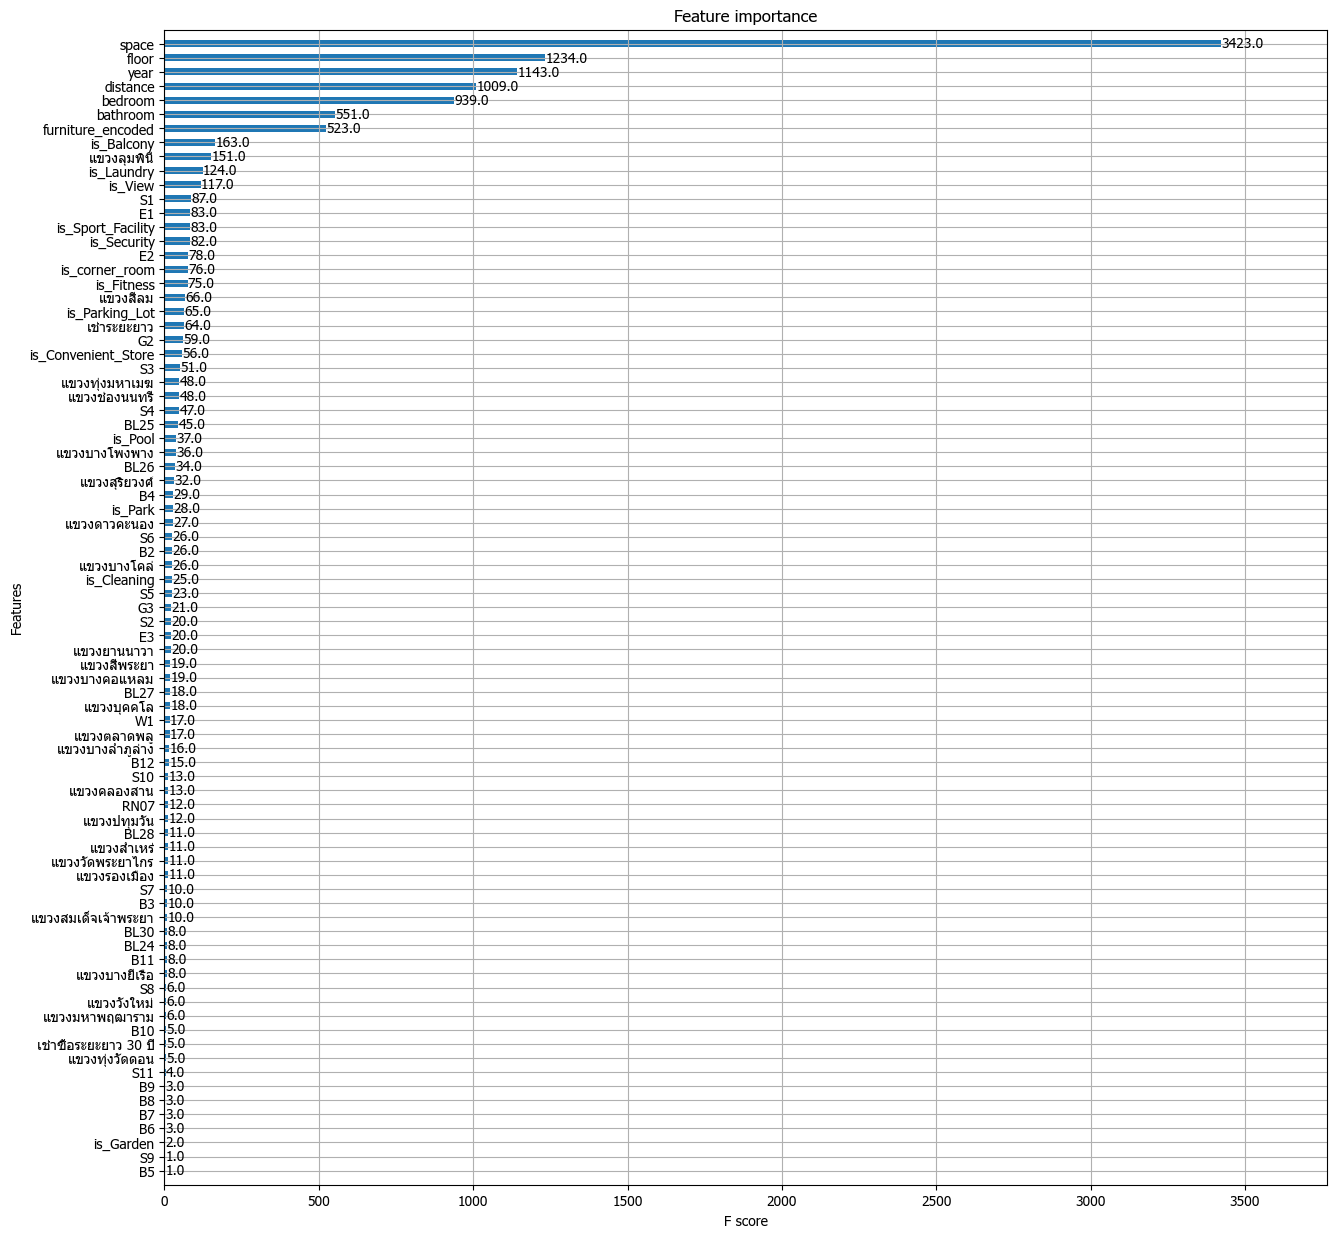

In [237]:
import xgboost as xgb
from xgboost import XGBRegressor
xgbr = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.1)
# fit model
xgbr.fit(X_train, y_train)
# make predictions
y_pred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE on the test set:', rmse)
print(xgbr.get_params())

fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_importance(xgbr, height=0.5, ax=ax)
plt.show()

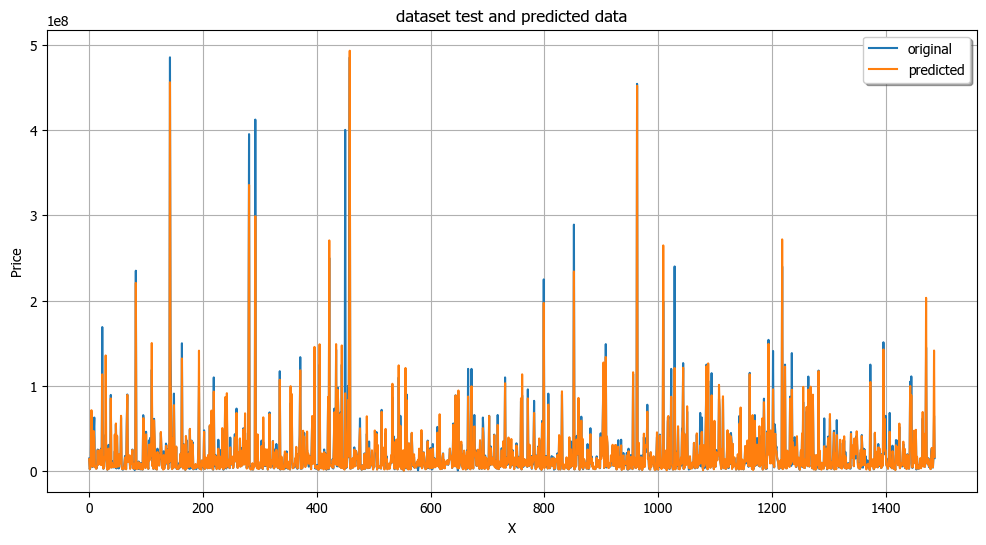

In [220]:
x_ax = range(len(y_test))
plt.figure(figsize=(15, 15))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

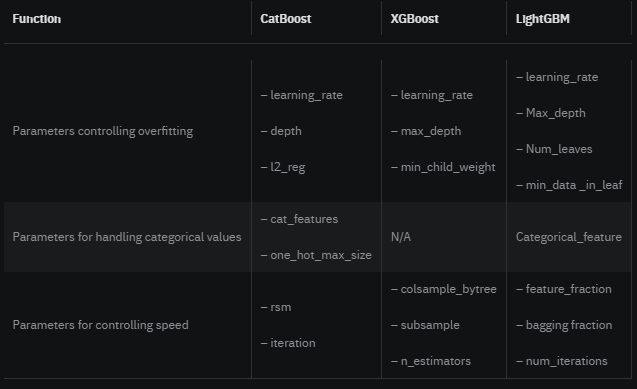

## CatBoost

In [221]:
# {'learning_rate': 0.08573657439690582, 'loss_function': 'RMSE', 'thread_count': 2, 'random_seed': 10242048, 'verbose': False, 'train_dir': 'catboost_1682587330.4926345', 'n_estimators': 441, 'early_stopping_rounds': 15}


0:	learn: 36733874.5489601	total: 2.73ms	remaining: 817ms
1:	learn: 34263991.5855516	total: 5.72ms	remaining: 852ms
2:	learn: 32110021.4730425	total: 7.81ms	remaining: 773ms
3:	learn: 30341214.6661234	total: 9.92ms	remaining: 734ms
4:	learn: 28508306.0581182	total: 12.1ms	remaining: 714ms
5:	learn: 26721148.3262733	total: 14.7ms	remaining: 720ms
6:	learn: 25387580.2861154	total: 17.6ms	remaining: 735ms
7:	learn: 24019341.6852079	total: 20.3ms	remaining: 741ms
8:	learn: 22742852.1383370	total: 23.3ms	remaining: 755ms
9:	learn: 21658610.3536078	total: 26.1ms	remaining: 758ms
10:	learn: 20705351.3779507	total: 28.6ms	remaining: 750ms
11:	learn: 19907031.2237491	total: 31.3ms	remaining: 751ms
12:	learn: 19040531.1736576	total: 35ms	remaining: 773ms
13:	learn: 18159309.5275771	total: 37.5ms	remaining: 767ms
14:	learn: 17403436.7824261	total: 42.2ms	remaining: 801ms
15:	learn: 16766726.8478059	total: 50.5ms	remaining: 896ms
16:	learn: 16179926.9436790	total: 57.6ms	remaining: 958ms
17:	learn

Text(0.5, 1.0, 'Feature Importance')

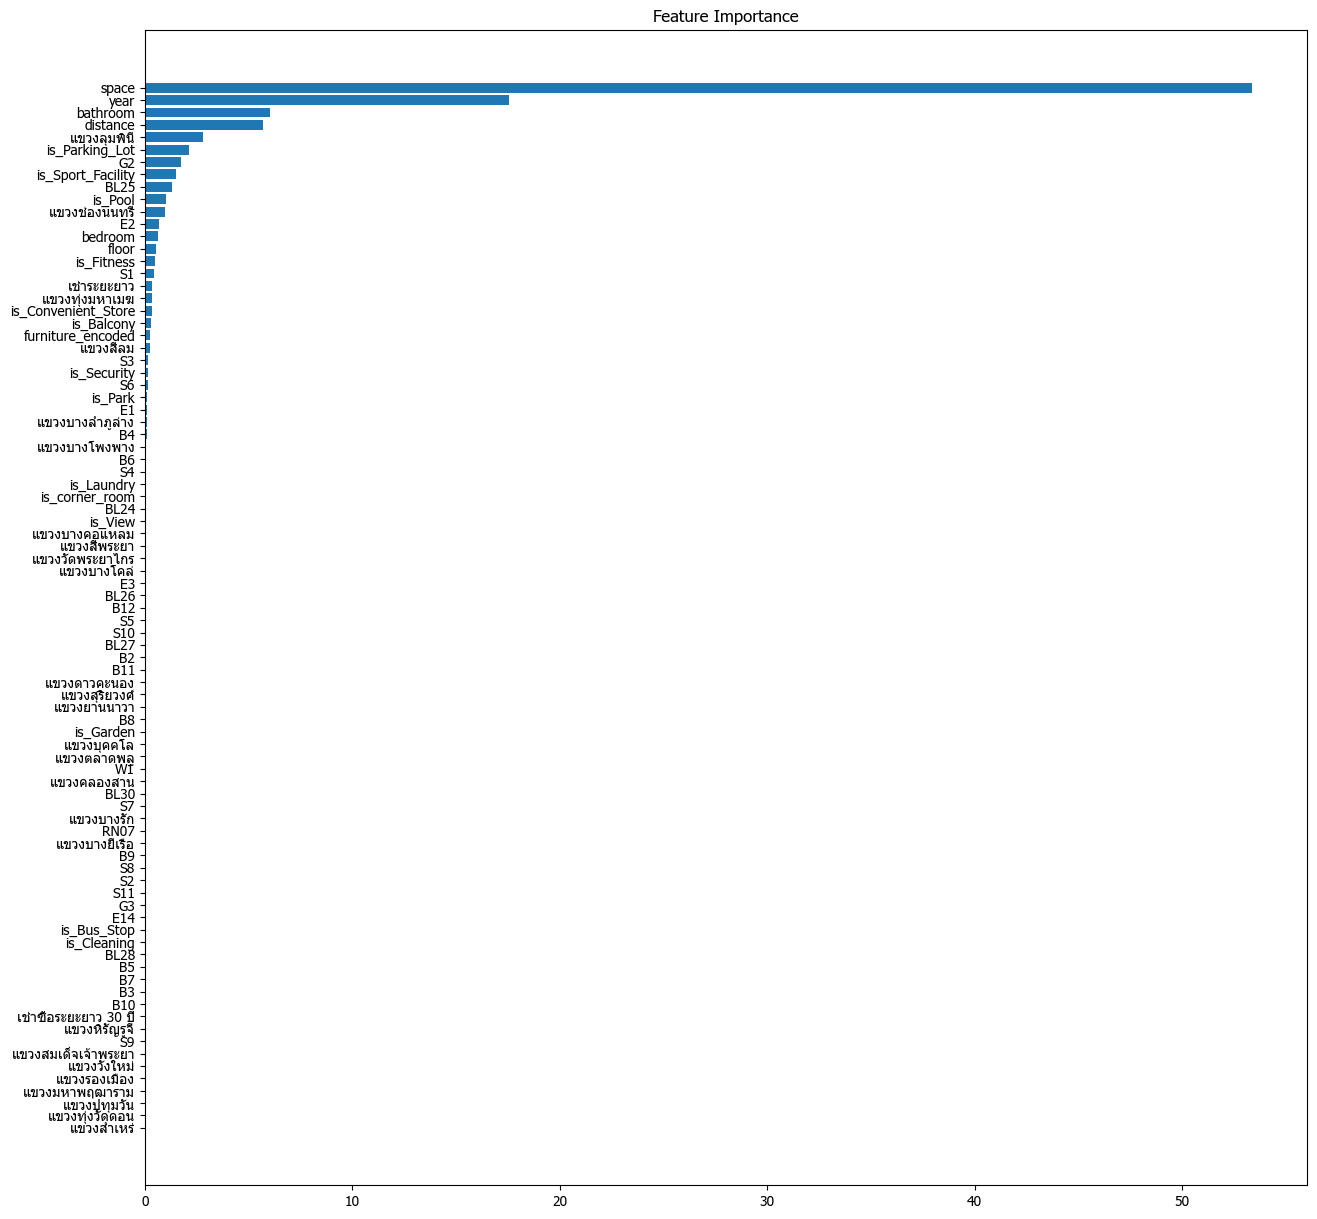

In [238]:
import catboost as cb
from catboost import CatBoostRegressor
cbr = CatBoostRegressor(n_estimators=300, max_depth=6, learning_rate=0.1,  loss_function= 'RMSE' )
# fit model
cbr.fit(X_train, y_train)
# make predictions
y_pred = cbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE on the test set:', rmse)
print(cbr.get_params())

feature_importance = cbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(15, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

<a id="4"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 5. Prediction </p>

คณะผู้จัดทำได้ scraped ข้อมูลทั้งหมดในการทำ Model ในวันที่ 9 เมษายน 2566 อย่างไรก็ดี เนื่องจากต้องการข้อมูลที่ใช้ในการ Predict จึงได้มีการดึงข้อมูลเพิ่มจากเว็บไซต์ เพื่อเป็นตัวอย่างในการวัด Performance ของ Model
* The Key พระราม 3 -> ราคา 7,290,000 บาท
* IDEO Chula-Samyan -> ราคา 5,100,000 บาท

In [223]:
predict_data = [
       [2.0, 1.0, 53.0, 2022.0, 26.0, 30.0,
       True, False, True, False, False, True, False, False, False, False,
       True, True, False, True, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], #>> The Key 7.29M
       
       [1.0, 1.0, 34.5, np.nan, np.nan, 450.0,
       True, False, False, False, False, True, False, False, False, False,
       True, True, False, False, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]] # >> IDEO 5.1M 

predict_df = pd.DataFrame(predict_data)

In [224]:
predict_df.columns = ['bedroom', 'bathroom', 'space', 'year', 'floor',
       'distance', 'is_Security', 'is_Laundry', 'is_Parking_Lot',
       'is_Bus_Stop', 'is_Cleaning', 'is_Fitness', 'is_Convenient_Store',
       'is_Balcony', 'is_View', 'is_Sport_Facility', 'is_Pool', 'is_Park',
       'is_Garden', 'is_corner_room', 'furniture_encoded', 'แขวงคลองสาน',
       'แขวงช่องนนทรี', 'แขวงดาวคะนอง', 'แขวงตลาดพลู', 'แขวงทุ่งมหาเมฆ',
       'แขวงทุ่งวัดดอน', 'แขวงบางคอแหลม', 'แขวงบางยี่เรือ', 'แขวงบางรัก',
       'แขวงบางลำภูล่าง', 'แขวงบางโคล่', 'แขวงบางโพงพาง', 'แขวงบุคคโล',
       'แขวงปทุมวัน', 'แขวงมหาพฤฒาราม', 'แขวงยานนาวา', 'แขวงรองเมือง',
       'แขวงลุมพินี', 'แขวงวังใหม่', 'แขวงวัดพระยาไกร', 'แขวงสมเด็จเจ้าพระยา',
       'แขวงสำเหร่', 'แขวงสีลม', 'แขวงสี่พระยา', 'แขวงสุริยวงศ์',
       'แขวงหิรัญรูจี', 'เช่าซื้อระยะยาว 30 ปี', 'เช่าระยะยาว', 'B10', 'B11',
       'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'BL24', 'BL25',
       'BL26', 'BL27', 'BL28', 'BL30', 'E1', 'E14', 'E2', 'E3', 'G2', 'G3',
       'RN07', 'S1', 'S10', 'S11', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8',
       'S9', 'W1']

In [225]:
predict_df

,bedroom,bathroom,space,year,floor,distance,is_Security,is_Laundry,is_Parking_Lot,is_Bus_Stop,is_Cleaning,is_Fitness,is_Convenient_Store,is_Balcony,is_View,is_Sport_Facility,is_Pool,is_Park,is_Garden,is_corner_room,furniture_encoded,แขวงคลองสาน,แขวงช่องนนทรี,แขวงดาวคะนอง,แขวงตลาดพลู,แขวงทุ่งมหาเมฆ,แขวงทุ่งวัดดอน,แขวงบางคอแหลม,แขวงบางยี่เรือ,แขวงบางรัก,แขวงบางลำภูล่าง,แขวงบางโคล่,แขวงบางโพงพาง,แขวงบุคคโล,แขวงปทุมวัน,แขวงมหาพฤฒาราม,แขวงยานนาวา,แขวงรองเมือง,แขวงลุมพินี,แขวงวังใหม่,แขวงวัดพระยาไกร,แขวงสมเด็จเจ้าพระยา,แขวงสำเหร่,แขวงสีลม,แขวงสี่พระยา,แขวงสุริยวงศ์,แขวงหิรัญรูจี,เช่าซื้อระยะยาว 30 ปี,เช่าระยะยาว,B10,B11,B12,B2,B3,B4,B5,B6,B7,B8,B9,BL24,BL25,BL26,BL27,BL28,BL30,E1,E14,E2,E3,G2,G3,RN07,S1,S10,S11,S2,S3,S4,S5,S6,S7,S8,S9,W1
0,2.0,1.0,53.0,2022.0,26.0,30.0,True,False,True,False,False,True,False,False,False,False,True,True,False,True,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,34.5,NaN,NaN,450.0,True,False,False,False,False,True,False,False,False,False,True,True,False,False,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [226]:
actual = np.array([7290000, 5100000])
place = np.array(['The Key Rama 3', 'IDEO Chula-Samyan'])
result = best_model.predict(predict_df)
result_lgb = lgbm.predict(predict_df)
result_xgb = xgbr.predict(predict_df)
result_cb = cbr.predict(predict_df)


In [227]:
for i,j,z in zip(place,actual,result):
    print(i)
    print(f"Actual Price: {j:,} THB")
    print(f"Predicted Price: {z:,.0f} THB \n")

The Key Rama 3
Actual Price: 7,290,000 THB
Predicted Price: 7,733,180 THB 

IDEO Chula-Samyan
Actual Price: 5,100,000 THB
Predicted Price: 19,203,736 THB 



In [228]:
for i,j,z in zip(place,actual,result_xgb):
    print(i)
    print(f"Actual Price: {j:,} THB")
    print(f"Predicted Price: {z:,.0f} THB \n")

The Key Rama 3
Actual Price: 7,290,000 THB
Predicted Price: 6,966,629 THB 

IDEO Chula-Samyan
Actual Price: 5,100,000 THB
Predicted Price: 5,474,195 THB 



In [229]:
for i,j,z in zip(place,actual,result_cb):
    print(i)
    print(f"Actual Price: {j:,} THB")
    print(f"Predicted Price: {z:,.0f} THB \n")

The Key Rama 3
Actual Price: 7,290,000 THB
Predicted Price: 7,164,454 THB 

IDEO Chula-Samyan
Actual Price: 5,100,000 THB
Predicted Price: 6,110,490 THB 



In [230]:
for i,j,z in zip(place,actual,result_lgb):
    print(i)
    print(f"Actual Price: {j:,} THB")
    print(f"Predicted Price: {z:,.0f} THB \n")

The Key Rama 3
Actual Price: 7,290,000 THB
Predicted Price: 7,317,185 THB 

IDEO Chula-Samyan
Actual Price: 5,100,000 THB
Predicted Price: 5,300,539 THB 



<a id="5"></a>
# <p style="  padding:20px; border:5px Outset #EBEBEB; background-color:#4B0082; font-family:'Times_New_Roman'; text-align:left; font-size:25px; font-weight:1000; color: #EBEBEB"> 6. Reference </p>
Scraping เพื่อดึงข้อมูลแต่ละคอนโดในแต่ละเขต วันที่ทำการ scraped ข้อมูล 9 เมษายน 2566

Source:
- [Yannawa](https://www.ddproperty.com/รวมประกาศขาย?freetext=ยานนาวา&listing_type=sale&market=residential&property_type=N&district_code[]=TH1012&property_type_code[]=CONDO&search=true)
- [Bang Kho Laem](https://www.ddproperty.com/รวมประกาศขาย?freetext=บางคอแหลม&listing_type=sale&market=residential&property_type=N&district_code[]=TH1031&property_type_code[]=CONDO&search=true)
- [Thonburi](https://www.ddproperty.com/รวมประกาศขาย?freetext=ธนบุรี&listing_type=sale&market=residential&property_type=N&district_code[]=TH1015&property_type_code[]=CONDO&search=true)
- [Sathorn](https://www.ddproperty.com/รวมประกาศขาย?freetext=สาทร&listing_type=sale&market=residential&property_type=N&district_code[]=TH1028&property_type_code[]=CONDO&search=true)
- [Khlong San](https://www.ddproperty.com/รวมประกาศขาย?freetext=คลองสาน&listing_type=sale&market=residential&property_type=N&property_type_code[]=CONDO&district_code[]=TH1018&search=true)
- [Pathumwan](https://www.ddproperty.com/รวมประกาศขาย?freetext=ปทุมวัน&listing_type=sale&market=residential&property_type=N&property_type_code[]=CONDO&district_code[]=TH1007&search=true)
- [Bang Rak](https://www.ddproperty.com/รวมประกาศขาย?freetext=บางรัก&listing_type=sale&market=residential&property_type=N&property_type_code[]=CONDO&district_code[]=TH1004&search=true)
